# Fraud Detection in Credit Card Dataset

## 1. Introduction

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

## 2. Data Analysis Approaches

In this dataset we will use Anomaly detection technique used to identify unusual patterns that do not conform to expected behavior, called outliers. Outlier detection and novelty detection are both used for anomaly detection, where one is interested in detecting abnormal or unusual observations. Outlier detection is then also known as unsupervised anomaly detection and novelty detection as semi-supervised anomaly detection. Sklearn helps us to make this analysis in which inliers are labeled 1, while outliers are labeled -1. 

We will focus on Outlier detection in the dataset, thus we will work just with training supsamples of our dataset.

**The goal of this notebook** is to find out some new techniques of data analysis specialized on anomaly detection namely:

**1. Isolation Forest Anomaly Detection Algorithm**

**2. Density-Based Anomaly Detection (Local Outlier Factor) Algorithm**

**3. Support Vector Machine Anomaly Detection Algorithm**

So, let's get started!

Fist of all, we will import some basic libraries and load the dataset:

In [21]:
#importing packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
import time
import matplotlib.patches as mpatches

data = pd.read_csv(r'C:\\Users\\ivetoshev\\Documents\\creditcard.csv')       
print("The dataframe has {} rows and {} columns".format(data.shape[0], data.shape[1]))
data.head(5)

The dataframe has 284807 rows and 31 columns


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Let's check wheather our dataset has some missing values.

In [4]:
data.isnull().sum().max()

0

The dataset has no missing values, so imputation of missing values is no needeed.

Then we will look how the datset is imbalanced: how many fraud and non-fraud transactions are there?

0    284315
1       492
Name: Class, dtype: int64


Text(0,0.5,'Frequency')

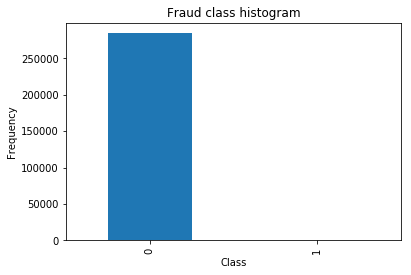

In [5]:
count_classes = pd.value_counts(data['Class'], sort = True).sort_index()
print(count_classes)
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

As we see, the dataset is highly imbalanced, just 432 fraud transactions vs. 284315 non-fraud transactions.
In our dataset, we don't need to use oversample (undersample) techniques, as the considered algorithms are specialized to find abnormal values.

Next, we want to know amount of money per transaction by each class for more understanding the dataset.

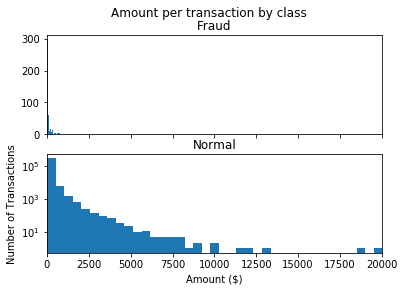

In [6]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 50
Fraud=data[data['Class']==1]
Normal=data[data['Class']==0]
ax1.hist(Fraud.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(Normal.Amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();


Amount per transactions rate of fraud data is low compared to the non-fraud data. It's an interesting result as I assumed that fraud transactions might be associated with big money.

As the dataset is quite big, we will select a subsample to make the analysis much faster. 

In [2]:
data = data.sample(frac=1, random_state=1234) #Shuffle rows

fraud_data = data.loc[data['Class'] == 1]
non_fraud_data = data.loc[data['Class'] == 0][:30000]

united_data = pd.concat([fraud_data, non_fraud_data])

new_data = united_data.sample(frac=1, random_state=42) #Shuffle rows
new_data.shape

(30492, 31)

Now the dasaset is much smaller but the size is still useful for our analysis.

## 3. ML Algorithms

### 3.1. T-SNE

Firstly, we're going to apply T-SNE algorithm. Briefy, T-SNE a non-linear dimensionality reduction algorithm (compared to PCA)  finds patterns in the data by identifying observed clusters based on similarity of data points with multiple features. But it is not a clustering algorithm it is a dimensionality reduction algorithm and the input features are no longer identifiable (you cannot make any inference based only on the output of t-SNE). Hence it is mainly a data exploration and visualization technique, but in our analysis it might be useful.

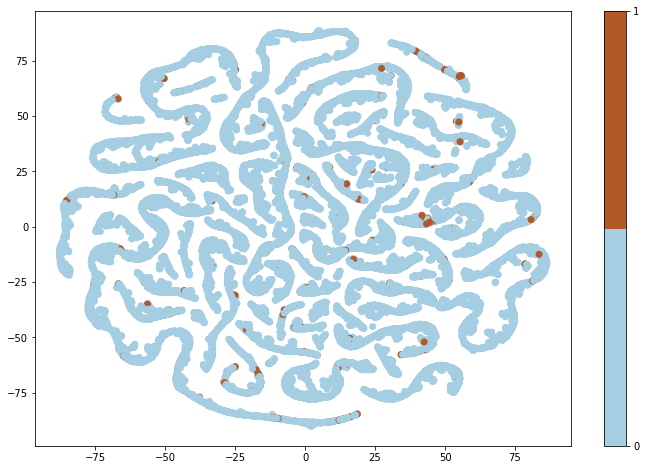

In [22]:
X = new_data.drop('Class', axis=1)
Y = new_data['Class']

# T-SNE Implementation
X_reduced_tsne = TSNE(n_components=2, random_state=555).fit_transform(X.values)
plt.figure(figsize=(12,8))
plt.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=Y, cmap=plt.cm.get_cmap("Paired", 2))
plt.colorbar(ticks=range(2))

As we see, T-SNE algorithm does not work as well as other techniques that would be considered on this dataset. Here, T-SNE cannot separate fraud values from non-fraud data. This is because the positive cases are not too far away from the normal cases. It's worth to mention that this problem is connected to the type of data of the particular dataset that we have here.

### 3.2. Isolation Forest algorithm

Firstly, we will consider **Isolation Forest algorithm**.

In [6]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
import sklearn.metrics as metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, auc
from sklearn.metrics import classification_report, accuracy_score

C:\Users\ivetoshev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


(array([3.000e+00, 6.000e+00, 3.000e+00, 3.000e+00, 1.000e+00, 1.000e+01,
        6.000e+00, 6.000e+00, 1.400e+01, 1.800e+01, 1.200e+01, 2.000e+01,
        7.000e+00, 7.000e+00, 3.000e+00, 9.000e+00, 2.000e+00, 4.000e+00,
        4.000e+00, 2.000e+00, 2.000e+00, 9.000e+00, 5.000e+00, 1.200e+01,
        7.000e+00, 1.000e+01, 1.400e+01, 9.000e+00, 1.000e+01, 8.000e+00,
        9.000e+00, 1.500e+01, 8.000e+00, 5.000e+00, 1.800e+01, 1.200e+01,
        1.900e+01, 2.200e+01, 2.200e+01, 2.200e+01, 2.900e+01, 2.700e+01,
        3.100e+01, 2.200e+01, 3.500e+01, 3.800e+01, 3.700e+01, 3.700e+01,
        5.000e+01, 4.000e+01, 3.200e+01, 3.000e+01, 4.100e+01, 5.300e+01,
        4.800e+01, 4.300e+01, 5.500e+01, 5.600e+01, 6.200e+01, 7.500e+01,
        5.800e+01, 7.300e+01, 7.700e+01, 8.200e+01, 1.060e+02, 1.000e+02,
        8.800e+01, 1.280e+02, 1.520e+02, 1.720e+02, 1.960e+02, 1.920e+02,
        2.500e+02, 2.350e+02, 3.240e+02, 3.650e+02, 4.200e+02, 4.380e+02,
        5.670e+02, 6.620e+02, 6.950e+0

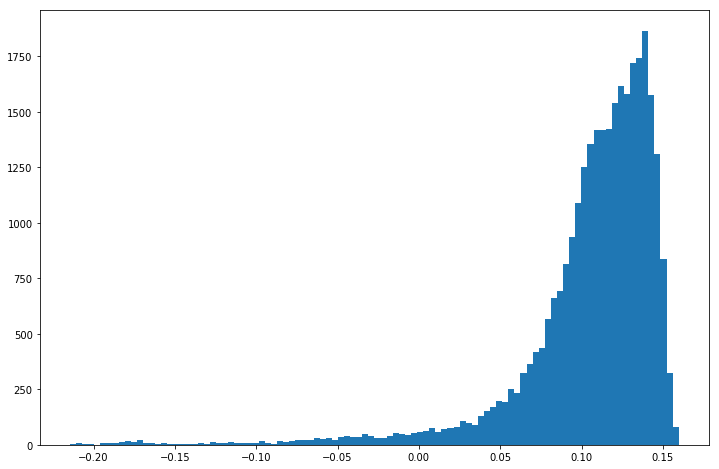

In [16]:
X_train = new_data.drop(['Class'], axis=1)
Y_train = new_data['Class']

clf = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.01, \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)

clf.fit(X_train)
scores_prediction = clf.decision_function(X_train)
plt.figure(figsize=(12, 8))
plt.hist(scores_prediction, bins=100)

In [17]:
X_train['Class']= Y_train
X_train['scores']= scores_prediction
X_train['prediction'] = ''

for i in range(X_train.shape[0]):
    if (X_train.iloc[i, 31]<=0):
        X_train.iloc[i, 32]=1
    else:
        X_train.iloc[i, 32]=0
        
matrix = confusion_matrix(X_train['Class'], X_train['prediction'], labels=[1, 0])
print(matrix)

precision, recall, thresholds = precision_recall_curve(X_train['Class'], -X_train['scores'])
area = auc(recall, precision)
print ("Area Under PR Curve(AP): %0.2f" % area)

[[  346   146]
 [  695 29305]]
Area Under PR Curve(AP): 0.56


### 3.3. Local Outlier Factor algorithm

Secondly, we will consider **Local Outlier Factor algorithm**.

C:\Users\ivetoshev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neighbors\lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


(array([1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00,
        2.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 3.0000e+00,
        2.0000e+00, 3.0000e+00, 1.0000e+00, 4.0000e+00, 5.0000e+00,
        1.0000e+00, 3.0000e+00, 6.0000e+00, 5.0000e+00, 4.0000e+00,
        5.0000e+00, 1.2000e+01, 1.0000e+01, 1.50

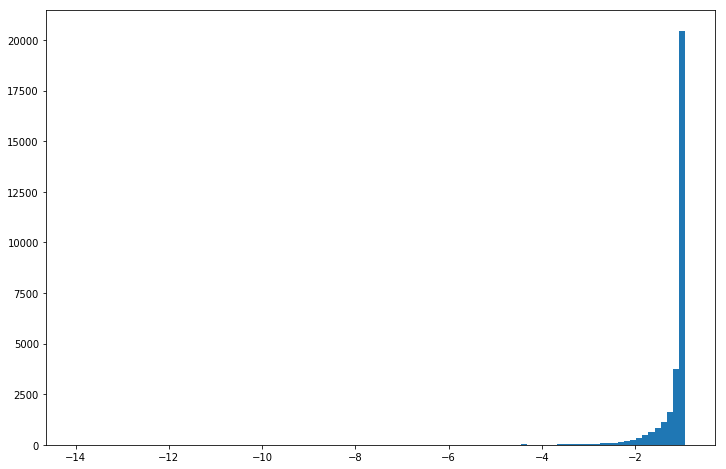

In [14]:
X_train = new_data.drop(['Class'], axis=1)
Y_train = new_data['Class']

clf = LocalOutlierFactor(algorithm='auto', metric='manhattan').fit(X_train) 
scores_prediction = clf.negative_outlier_factor_

plt.figure(figsize=(12, 8))
plt.hist(scores_prediction, bins=100)

In [15]:
X_train['Class']= Y_train
X_train['scores']= scores_prediction
X_train['prediction'] = ''

for i in range(X_train.shape[0]):
    if (X_train.iloc[i, 31]<-1.9):
        X_train.iloc[i, 32]=1
    else:
        X_train.iloc[i, 32]=0
        
matrix = confusion_matrix(X_train[['Class']], X_train[['prediction']], labels=[1, 0])
print(matrix)

precision, recall, thresholds = precision_recall_curve(X_train['Class'], -X_train['scores'])
area = auc(recall, precision)
print ("Area Under PR Curve(AP): %0.2f" % area)

[[   79   413]
 [ 1389 28611]]
Area Under PR Curve(AP): 0.04


### 3.3. Support Vector Machine algorithm (OneClassSVM)

Finally, we will consider **Support Vector Machine algorithm (OneClassSVM)**.

(array([2.9073e+04, 1.3740e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        4.0000e+00, 2.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00,
        1.0000e+00, 2.0000e+00, 0.0000e+00, 3.0000e+00, 2.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 2.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        2.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

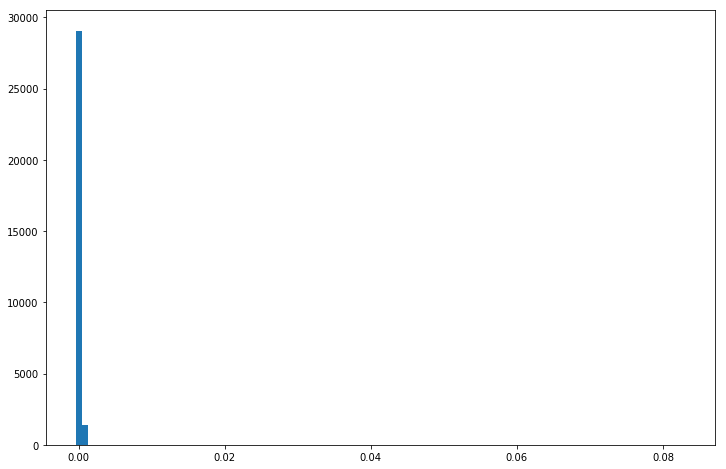

In [18]:
X_train = new_data.drop(['Class'], axis=1)
Y_train = new_data['Class']

clf = OneClassSVM(gamma='auto')

clf.fit(X_train)
scores_prediction = clf.decision_function(X_train)
prediction = clf.predict(X_train)
plt.figure(figsize=(12, 8))
plt.hist(scores_prediction, bins=100)

In [20]:
prediction[prediction == 1] = 0
prediction[prediction == -1] = 1

X_train['Class']= Y_train
X_train['scores']= scores_prediction
X_train['prediction'] = prediction
   
matrix = confusion_matrix(X_train['Class'], X_train['prediction'], labels=[1, 0])
print(matrix)

precision, recall, thresholds = precision_recall_curve(X_train['Class'], X_train['scores'])
area = auc(recall, precision)
print ("Area Under PR Curve(AP): %0.2f" % area)

[[  278   214]
 [15725 14275]]
Area Under PR Curve(AP): 0.02


## <font color=black>4. Results</font> 

We considered 3 following algorithms: **Isolation Forest**, **Local Outlier Factor detecting** and **OneClassSVM for Anomaly detection (Outlier detection)**. Also we used non-linear dimensionality reduction called **T-SNE**.

- Generally, T-SNE is a good dimensionality reduction technique, but in this case it doesn't work pretty well on this dataset. We cannot see two accurate clusters for fraud and non-fraud data. Probably, this is because the fraud values are not too far away from the normal values.
- According to AUC under Precision-Recall Curve, **the best algorithms for Outlier detection is Isolation forest**. It showed much higher AUC-PR (0.56) among examied algorithms, but the AUC value is still could to be improved by using the other approaches for Outlier detection.
- Isolation forest took the least time among the algorithms. This characteristic could be useful for business tasks.
- It's worth to mention that AUC-PR is more appropriate method to evaluate the models because it allows to consider imbalanced data. Using of AUC-ROC curve will lead to wrong results at this case!
